# Used Car Quality Prediction using Machine Learning

![](https://thumbs.dreamstime.com/z/aerial-view-auto-auction-many-used-car-lot-parked-distributed-parking-top-217318988.jpg)

In this project, used cars' quality prediction will be made, precisely if a car bought at an auction is a good buy or a bad buy for the dealer, using information like its vehicle age, transmission type, odometer reading etc. The dataset used here is taken from the [Don't Get Kicked!](https://www.kaggle.com/c/DontGetKicked) competition on [Kaggle](https://kaggle.com). The following steps will be followed to develop the prediction model:

1. Download and explore the data.
2. Prepare the dataset for training and evaluation of models.
3. Train a logistic regression model and a decision tree model.
4. Make predictions and evaluate the models on the training dataset as well as validation dataset.
5. Hyperparameters tuning to obtain the best fit considering both training and validation datasets. 

# course-project-ml

## Download, Explore the Data and Prepare the dataset for training

The dataset is available as ZIP file as well as csv file at the following url. Along with train and test data, there are two other files. One of them contains definitions of all the training features available to develop the models. The opendatasets library is used to download the dataset.



In [ ]:
dataset_url = "https://www.kaggle.com/c/DontGetKicked"

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abhikr159
Your Kaggle Key: ··········


100%|██████████| 10.2M/10.2M [00:00<00:00, 100MB/s]


Extracting archive ./DontGetKicked/DontGetKicked.zip to ./DontGetKicked


In [ ]:
import os

In [ ]:
data_dir = '/content/DontGetKicked'

In [ ]:
os.listdir(data_dir)

['test.csv',
 'training.csv',
 'Carvana_Data_Dictionary.txt',
 'training.zip',
 'test.zip',
 'example_entry.csv']

In [ ]:
train_csv = data_dir + '/training.csv'

In [ ]:
test_csv = data_dir + '/test.csv'

In [ ]:
definitions = data_dir + '/Carvana_Data_Dictionary.txt'

In [ ]:
with open(definitions, "r") as file1:
    FileContent = file1.read()
    print(FileContent)

Field Name				Definition
RefID				        Unique (sequential) number assigned to vehicles
IsBadBuy				Identifies if the kicked vehicle was an avoidable purchase 
PurchDate				The Date the vehicle was Purchased at Auction
Auction					Auction provider at which the  vehicle was purchased
VehYear					The manufacturer's year of the vehicle
VehicleAge				The Years elapsed since the manufacturer's year
Make					Vehicle Manufacturer 
Model					Vehicle Model
Trim					Vehicle Trim Level
SubModel				Vehicle Submodel
Color					Vehicle Color
Transmission				Vehicles transmission type (Automatic, Manual)
WheelTypeID				The type id of the vehicle wheel
WheelType				The vehicle wheel type description (Alloy, Covers)
VehOdo					The vehicles odometer reading
Nationality				The Manufacturer's country
Size					The size category of the vehicle (Compact, SUV, etc.)
TopThreeAmericanName			Identifies if the manufacturer is one of the top three American manufacturers
MMRAcquisitionAuctionAveragePrice	Acquisiti

In [ ]:
!pip install pandas --quiet

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

Loading the data from the file `train.csv` and `test.csv` into Pandas data frames.

In [ ]:
train_df = pd.read_csv(train_csv)

In [ ]:
test_df = pd.read_csv(test_csv)

In [ ]:
!pip install scikit-learn --upgrade --quiet

     |████████████████████████████████| 23.1 MB 1.6 MB/s 


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              72983 non-null  int64  
 1   IsBadBuy                           72983 non-null  int64  
 2   PurchDate                          72983 non-null  object 
 3   Auction                            72983 non-null  object 
 4   VehYear                            72983 non-null  int64  
 5   VehicleAge                         72983 non-null  int64  
 6   Make                               72983 non-null  object 
 7   Model                              72983 non-null  object 
 8   Trim                               70623 non-null  object 
 9   SubModel                           72975 non-null  object 
 10  Color                              72975 non-null  object 
 11  Transmission                       72974 non-null  obj

In [ ]:
train_df.IsBadBuy.value_counts()

0    64007
1     8976
Name: IsBadBuy, dtype: int64

### Handling Skewed nature of the dataset


The dataset is highly skewed in favour of 'a car not being a bad buy'. A naive model which just predicts every car to not be a bad buy would get accuracy as high as (64007/(64007+8976)) = 87% on the training dataset. However such a model is of no use to us as our model should work on test dataset even if the target classes are balanced. The dataset has to be modified in some way to tackle this issue. One way to overcome this issue is to oversample the minority class which means artificially generating new examples of minority class using already present examples of this class and adding to the training dataset.

In [ ]:
# Class count
count_class_0, count_class_1 = train_df.IsBadBuy.value_counts()

# Divide by class
class_0_df = train_df[train_df['IsBadBuy'] == 0]
class_1_df = train_df[train_df['IsBadBuy'] == 1]

Random over-sampling:
1    64007
0    64007
Name: IsBadBuy, dtype: int64


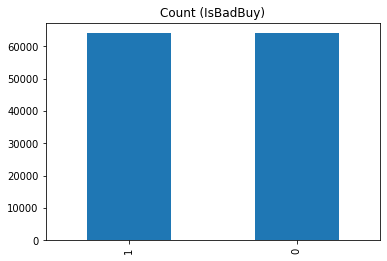

In [ ]:
class_1_df_over = class_1_df.sample(count_class_0, replace=True)
test_over_df = pd.concat([class_0_df, class_1_df_over], axis=0)

print('Random over-sampling:')
print(test_over_df.IsBadBuy.value_counts())

test_over_df.IsBadBuy.value_counts().plot(kind='bar', title='Count (IsBadBuy)');

### Picking features and classifying them
Renaming the obtained dataset after oversampling as 'train_val_df' as this dataset will further be split into train and validation datasets. Going through the dataset, the target column for the model is 'IsBadBuy' and rest are going to be training features. The features are both categoric as well as numeric. The features are manually divided into categoric and numeric features. Few features are discarded like 'RefId', 'BYRNO' as these are just unique ids. Also 'WheelTypeID' is a reduntant feature as this is essentially same as 'WheelType'. I have also discarded 'PurchDate' assuming it to not be significant.

In [ ]:
train_val_df = test_over_df

In [ ]:
train_val_df.sample(10)

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
27241,27259,0,8/26/2010,OTHER,2006,4,SUZUKI,FORENZA,NaN,4D SEDAN,MAROON,MANUAL,1.0,Alloy,66370,OTHER ASIAN,MEDIUM,OTHER,3582.0,4643.0,6854.0,8361.0,3641.0,4749.0,6872.0,8138.0,NaN,NaN,8655,73108,OK,3395.0,0,533
31953,31975,1,9/4/2009,OTHER,2006,3,DODGE,CARAVAN FWD V6 3.3L,SE,MINIVAN 3.3L,BLUE,AUTO,NaN,NaN,69926,AMERICAN,VAN,CHRYSLER,5603.0,7281.0,6551.0,8363.0,5684.0,7352.0,6639.0,8440.0,NaN,NaN,18880,29461,SC,6400.0,0,1411
21289,21304,1,1/22/2009,MANHEIM,2005,4,FORD,TAURUS 3.0L V6 EFI,SE,4D SEDAN SE FFV,WHITE,AUTO,1.0,Alloy,72402,AMERICAN,MEDIUM,FORD,3978.0,4927.0,4796.0,5821.0,4679.0,5731.0,5553.0,6689.0,NaN,NaN,20833,76040,TX,3960.0,0,920
41353,41376,0,7/15/2010,MANHEIM,2006,4,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 3.7L,BLUE,AUTO,1.0,Alloy,56508,AMERICAN,LARGE TRUCK,CHRYSLER,9798.0,12017.0,14737.0,17214.0,10229.0,11837.0,14602.0,16218.0,NaN,NaN,52598,29532,SC,10715.0,0,505
39564,39587,0,11/24/2009,MANHEIM,2006,3,PONTIAC,GRAND PRIX,Bas,4D SEDAN,BLUE,AUTO,1.0,Alloy,66791,AMERICAN,LARGE,GM,6553.0,8221.0,7577.0,9379.0,6261.0,7634.0,9921.0,11584.0,NaN,NaN,20234,85353,AZ,7345.0,0,1703
6461,6468,1,4/27/2010,MANHEIM,2001,9,CHEVROLET,VENTURE FWD V6,Plu,PASSENGER EXT 3.4L,SILVER,AUTO,1.0,Alloy,94863,AMERICAN,VAN,GM,2316.0,3071.0,4769.0,5265.0,2141.0,2726.0,5049.0,5932.0,NaN,NaN,835,85040,AZ,3880.0,0,5913
22601,22617,1,1/7/2010,MANHEIM,2006,4,MITSUBISHI,GALANT 4C,ES,4D SEDAN ES,WHITE,AUTO,2.0,Covers,73842,OTHER ASIAN,MEDIUM,OTHER,5966.0,7523.0,9589.0,10984.0,6167.0,7375.0,10512.0,12571.0,NaN,NaN,10430,76040,TX,5375.0,1,569
64193,64224,1,1/13/2010,ADESA,2004,6,NISSAN,XTERRA 2WD V6,SE,4D SPORT UTILITY SE SUPERCHARGED,SILVER,AUTO,2.0,Covers,81288,TOP LINE ASIAN,MEDIUM SUV,OTHER,7700.0,8560.0,11681.0,12666.0,7691.0,8551.0,11831.0,12982.0,NaN,NaN,21053,85226,AZ,8455.0,0,1373
24409,24427,0,10/21/2009,OTHER,2004,5,MAZDA,MAZDA6 3.0L V6 MPI,s,4D SEDAN S,SILVER,AUTO,1.0,Alloy,70289,OTHER ASIAN,MEDIUM,OTHER,6537.0,8496.0,7560.0,9676.0,5102.0,6456.0,8760.0,10093.0,NaN,NaN,18881,29697,SC,7900.0,0,1506
33023,33045,1,10/2/2009,OTHER,2003,6,HYUNDAI,ACCENT 1.6L I4 MPI,GL,4D SEDAN GL,WHITE,AUTO,NaN,NaN,51100,OTHER ASIAN,COMPACT,OTHER,2030.0,2784.0,2692.0,3507.0,2030.0,2784.0,2692.0,3507.0,NaN,NaN,21973,32750,FL,4115.0,0,1054


In [ ]:
target_column = 'IsBadBuy'

In [ ]:
categoric_features = ['Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART', 'VNZIP1', 'VNST']

In [ ]:
numeric_features = ['VehYear', 'VehicleAge', 'VehOdo'] + list(train_val_df.columns)[18:26] + ['VehBCost', 'IsOnlineSale', 'WarrantyCost']

In [ ]:
ignored_features = ['RefId', 'PurchDate', 'WheelTypeID', 'BYRNO']

In [ ]:
len(categoric_features), len(numeric_features), len(ignored_features)

(15, 14, 4)

Feature 'VNZIP1' is PIN(ZIP) code of the area. The values in the column are typecasted as 'object'.

In [ ]:
train_val_df[['VNZIP1']] = train_val_df[['VNZIP1']].astype('object')
test_df[['VNZIP1']] = test_df[['VNZIP1']].astype('object')

The numeric features are then plotted in form of histogram so that the data is easily visualised and understood.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f29e4186910>,
      dtype=object)

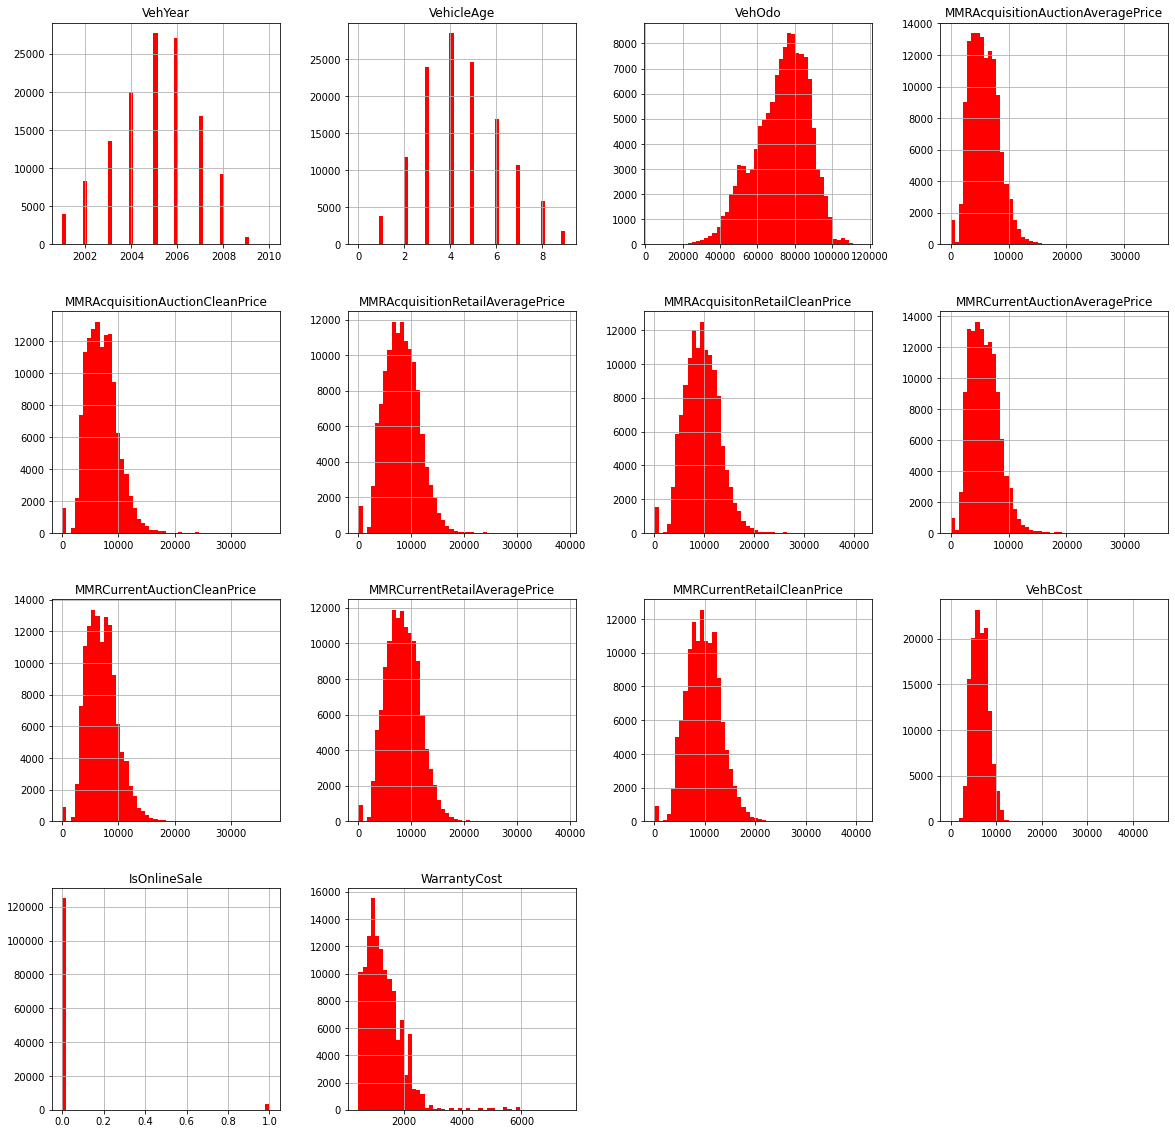

In [ ]:
train_val_df[numeric_features].hist(color='r', bins=50, figsize=(20,20))

Let's also check out characteristics of categoric features.

In [ ]:
train_val_df[categoric_features].describe()

,Auction,Make,Model,Trim,SubModel,Color,Transmission,WheelType,Nationality,Size,TopThreeAmericanName,PRIMEUNIT,AUCGUART,VNZIP1,VNST
count,128014,128014,128014,123359,128002,128002,128001,111136,128009,128009,128009,4200,4200,128014,128014
unique,3,33,1063,134,863,16,3,3,4,12,4,2,2,153,37
top,MANHEIM,CHEVROLET,PT CRUISER,Bas,4D SEDAN,SILVER,AUTO,Alloy,AMERICAN,MEDIUM,GM,NO,GREEN,32824,TX
freq,69994,27436,4983,24677,26723,26206,123592,60399,106227,52675,41915,4091,4076,5762,25100


In [ ]:
test_df[categoric_features].describe()

,Auction,Make,Model,Trim,SubModel,Color,Transmission,WheelType,Nationality,Size,TopThreeAmericanName,PRIMEUNIT,AUCGUART,VNZIP1,VNST
count,48707,48707,48707,47157,48702,48703,48704,46519,48700,48700,48700,2516,2516,48707,48707
unique,3,30,966,128,755,17,2,3,4,12,4,2,2,124,32
top,MANHEIM,CHEVROLET,PT CRUISER,Bas,4D SEDAN,SILVER,AUTO,Alloy,AMERICAN,MEDIUM,GM,NO,GREEN,75141,FL
freq,27736,11486,1813,9630,10209,10083,47010,25443,40413,20361,16957,2468,2470,2645,8642


### Weeding out extra highly correlated features
Sometimes, two or more features can be very closely related implying only one of them is enough to contibute approximately same information to the model. These extra features can lead to poor performance of our model. Using '.corr()' on dataframe, correlation matrix is obtained and we can weed out the extra features causing redundancy.

In [ ]:
corrM = train_val_df[numeric_features].corr()

In [ ]:
corrM

,VehYear,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VehBCost,IsOnlineSale,WarrantyCost
VehYear,1.000000,-0.960728,-0.309093,0.584185,0.546958,0.583762,0.549110,0.592877,0.558862,0.599892,0.566553,0.364049,0.064564,-0.318025
VehicleAge,-0.960728,1.000000,0.339730,-0.568545,-0.532433,-0.470891,-0.443030,-0.576944,-0.542586,-0.505882,-0.477548,-0.328749,-0.032955,0.305564
VehOdo,-0.309093,0.339730,1.000000,-0.076899,-0.041209,-0.029276,-0.002589,-0.082104,-0.047539,-0.039676,-0.013482,-0.117278,0.017684,0.395884
MMRAcquisitionAuctionAveragePrice,0.584185,-0.568545,-0.076899,1.000000,0.991849,0.917616,0.917269,0.950356,0.945164,0.884589,0.884052,0.805876,0.038012,-0.094132
MMRAcquisitionAuctionCleanPrice,0.546958,-0.532433,-0.041209,0.991849,1.000000,0.911689,0.924582,0.938315,0.945173,0.875363,0.884462,0.798265,0.037164,-0.068249
MMRAcquisitionRetailAveragePrice,0.583762,-0.470891,-0.029276,0.917616,0.911689,1.000000,0.991302,0.869080,0.866700,0.928659,0.922182,0.761796,0.079183,-0.097047
MMRAcquisitonRetailCleanPrice,0.549110,-0.443030,-0.002589,0.917269,0.924582,0.991302,1.000000,0.864782,0.871952,0.919075,0.922233,0.760369,0.075646,-0.074056
MMRCurrentAuctionAveragePrice,0.592877,-0.576944,-0.082104,0.950356,0.938315,0.869080,0.864782,1.000000,0.991686,0.920945,0.918813,0.802171,0.038677,-0.097246
MMRCurrentAuctionCleanPrice,0.558862,-0.542586,-0.047539,0.945164,0.945173,0.866700,0.871952,0.991686,1.000000,0.915652,0.926986,0.798319,0.038424,-0.072692
MMRCurrentRetailAveragePrice,0.599892,-0.505882,-0.039676,0.884589,0.875363,0.928659,0.919075,0.920945,0.915652,1.000000,0.990901,0.773608,0.076051,-0.099513


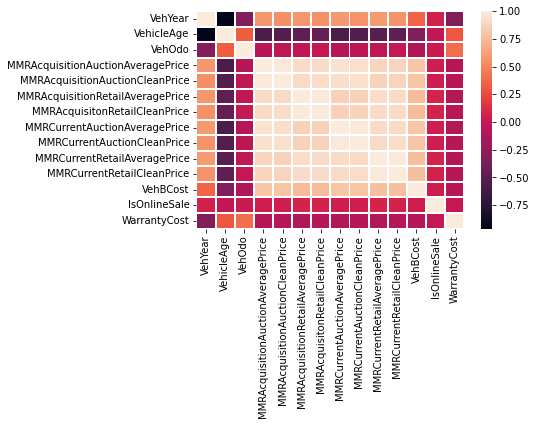

In [ ]:
hm = sn.heatmap(data = corrM, linewidths=1)

From the correlation matrix, we can see few of the features are highly correlated. Therefore, these features are removed from the list of selected features.

In [ ]:
numeric_features.remove('VehYear')
numeric_features.remove('MMRAcquisitionAuctionCleanPrice')
numeric_features.remove('MMRAcquisitonRetailCleanPrice')
numeric_features.remove('MMRCurrentAuctionCleanPrice')
numeric_features.remove('MMRCurrentRetailCleanPrice')

In [ ]:
numeric_features

['VehicleAge',
 'VehOdo',
 'MMRAcquisitionAuctionAveragePrice',
 'MMRAcquisitionRetailAveragePrice',
 'MMRCurrentAuctionAveragePrice',
 'MMRCurrentRetailAveragePrice',
 'VehBCost',
 'IsOnlineSale',
 'WarrantyCost']

### Handling NaN values
The dataset contains some rows where data against all features are not available. So we have to artificially put some value in those missing cells. This is known as imputing values. Values are missing for both categoric as well as numeric features.
Here, two different simple imputing strategies are adopted to handle NaN values. For numeric features, the NaN value is replaced by the mean value of the feature for all rows whereas in case of categoric feature, the most frequent element replaces the NaN value for the feature.
However, there are few exceptions which are 'PRIMEUNIT', 'AUCGUART' and 'WheelType'. For these features, the numbers of rows with NaN value are significantly large. So, the NaN value for these features are replaced by 'UNKNOWN'.

In [ ]:
train_val_df[numeric_features].isna().sum()

VehicleAge                             0
VehOdo                                 0
MMRAcquisitionAuctionAveragePrice     24
MMRAcquisitionRetailAveragePrice      24
MMRCurrentAuctionAveragePrice        514
MMRCurrentRetailAveragePrice         514
VehBCost                               0
IsOnlineSale                           0
WarrantyCost                           0
dtype: int64

In [ ]:
train_val_df[categoric_features].isna().sum()

Auction                      0
Make                         0
Model                        0
Trim                      4655
SubModel                    12
Color                       12
Transmission                13
WheelType                16878
Nationality                  5
Size                         5
TopThreeAmericanName         5
PRIMEUNIT               123814
AUCGUART                123814
VNZIP1                       0
VNST                         0
dtype: int64

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
imputer = SimpleImputer(strategy = 'mean')

In [ ]:
imputer.fit(train_val_df[numeric_features])

SimpleImputer()

In [ ]:
train_val_df[numeric_features] = imputer.transform(train_val_df[numeric_features])
test_df[numeric_features] = imputer.transform(test_df[numeric_features])

In [ ]:
test_df[numeric_features].isna().sum()

VehicleAge                           0
VehOdo                               0
MMRAcquisitionAuctionAveragePrice    0
MMRAcquisitionRetailAveragePrice     0
MMRCurrentAuctionAveragePrice        0
MMRCurrentRetailAveragePrice         0
VehBCost                             0
IsOnlineSale                         0
WarrantyCost                         0
dtype: int64

In [ ]:
train_val_df[numeric_features].isna().sum()

VehicleAge                           0
VehOdo                               0
MMRAcquisitionAuctionAveragePrice    0
MMRAcquisitionRetailAveragePrice     0
MMRCurrentAuctionAveragePrice        0
MMRCurrentRetailAveragePrice         0
VehBCost                             0
IsOnlineSale                         0
WarrantyCost                         0
dtype: int64

Before imputing categoric features, replace all the occurrences of 'Manual' with 'MANUAL' as they both represent the same observation.

In [ ]:
train_val_df["Transmission"].replace("Manual", "MANUAL", inplace=True)
test_df["Transmission"].replace("Manual", "MANUAL", inplace=True)

In [ ]:
train_val_df[categoric_features].describe()

,Auction,Make,Model,Trim,SubModel,Color,Transmission,WheelType,Nationality,Size,TopThreeAmericanName,PRIMEUNIT,AUCGUART,VNZIP1,VNST
count,128014,128014,128014,123359,128002,128002,128001,111136,128009,128009,128009,4200,4200,128014,128014
unique,3,33,1063,134,863,16,2,3,4,12,4,2,2,153,37
top,MANHEIM,CHEVROLET,PT CRUISER,Bas,4D SEDAN,SILVER,AUTO,Alloy,AMERICAN,MEDIUM,GM,NO,GREEN,32824,TX
freq,69994,27436,4983,24677,26723,26206,123592,60399,106227,52675,41915,4091,4076,5762,25100


In [ ]:
train_val_df[['PRIMEUNIT', 'AUCGUART', 'WheelType']] = train_val_df[['PRIMEUNIT', 'AUCGUART', 'WheelType']].fillna(value='UNKNOWN')
test_df[['PRIMEUNIT', 'AUCGUART', 'WheelType']] = test_df[['PRIMEUNIT', 'AUCGUART', 'WheelType']].fillna(value='UNKNOWN')

In [ ]:
train_val_df[categoric_features].describe()

,Auction,Make,Model,Trim,SubModel,Color,Transmission,WheelType,Nationality,Size,TopThreeAmericanName,PRIMEUNIT,AUCGUART,VNZIP1,VNST
count,128014,128014,128014,123359,128002,128002,128001,128014,128009,128009,128009,128014,128014,128014,128014
unique,3,33,1063,134,863,16,2,4,4,12,4,3,3,153,37
top,MANHEIM,CHEVROLET,PT CRUISER,Bas,4D SEDAN,SILVER,AUTO,Alloy,AMERICAN,MEDIUM,GM,UNKNOWN,UNKNOWN,32824,TX
freq,69994,27436,4983,24677,26723,26206,123592,60399,106227,52675,41915,123814,123814,5762,25100


The number of distinct values in few categoric features are large. We can drop those features for our model to run within resoanable time.

In [ ]:
categoric_features.remove('Model')
categoric_features.remove('SubModel')
categoric_features.remove('Trim')
categoric_features.remove('VNZIP1')

In [ ]:
categoric_features

['Auction',
 'Make',
 'Color',
 'Transmission',
 'WheelType',
 'Nationality',
 'Size',
 'TopThreeAmericanName',
 'PRIMEUNIT',
 'AUCGUART',
 'VNST']

In [ ]:
categoric_imputer = SimpleImputer(strategy = 'most_frequent')

In [ ]:
categoric_imputer.fit(train_val_df[categoric_features])

SimpleImputer(strategy='most_frequent')

In [ ]:
train_val_df[categoric_features] = categoric_imputer.transform(train_val_df[categoric_features])
test_df[categoric_features] = categoric_imputer.transform(test_df[categoric_features])

In [ ]:
test_df[categoric_features].isna().sum()

Auction                 0
Make                    0
Color                   0
Transmission            0
WheelType               0
Nationality             0
Size                    0
TopThreeAmericanName    0
PRIMEUNIT               0
AUCGUART                0
VNST                    0
dtype: int64

In [ ]:
train_val_df[categoric_features].isna().sum()

Auction                 0
Make                    0
Color                   0
Transmission            0
WheelType               0
Nationality             0
Size                    0
TopThreeAmericanName    0
PRIMEUNIT               0
AUCGUART                0
VNST                    0
dtype: int64

In [ ]:
train_val_df[categoric_features].describe()

,Auction,Make,Color,Transmission,WheelType,Nationality,Size,TopThreeAmericanName,PRIMEUNIT,AUCGUART,VNST
count,128014,128014,128014,128014,128014,128014,128014,128014,128014,128014,128014
unique,3,33,16,2,4,4,12,4,3,3,37
top,MANHEIM,CHEVROLET,SILVER,AUTO,Alloy,AMERICAN,MEDIUM,GM,UNKNOWN,UNKNOWN,TX
freq,69994,27436,26218,123605,60399,106232,52680,41920,123814,123814,25100


### Scaling the numeric features
The numeric values corresponding to different features can vary a lot. Hence, to allow all features to have equal paricipation in model development, it is necessary to scale the numeric features. Here MinMaxScaler is used to scale the features which scales the feature down to range [0, 1].

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train_val_df[numeric_features])

MinMaxScaler()

In [ ]:
train_val_df[numeric_features] = scaler.transform(train_val_df[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])

In [ ]:
train_val_df[numeric_features].describe()

,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionRetailAveragePrice,MMRCurrentAuctionAveragePrice,MMRCurrentRetailAveragePrice,VehBCost,IsOnlineSale,WarrantyCost
count,128014.000000,128014.000000,128014.000000,128014.000000,128014.000000,128014.000000,128014.000000,128014.000000,128014.000000
mean,0.500185,0.613345,0.163016,0.209473,0.163185,0.215273,0.143581,0.024755,0.120571
std,0.196928,0.130657,0.071759,0.083357,0.070464,0.081527,0.041989,0.155379,0.090207
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.529263,0.108757,0.150205,0.109540,0.156858,0.112915,0.000000,0.055571
50%,0.444444,0.630514,0.156374,0.205860,0.157102,0.211899,0.140736,0.000000,0.107021
75%,0.666667,0.710223,0.209871,0.265276,0.208807,0.269908,0.170647,0.000000,0.166003
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Encoding categoric features
The machine learning algorithms work only when we provide numeric inputs. Therefore we need to convert the categoric features in numeric form before training models on these inputs. One way to achieve this is by adding a new feature corresponding to each distinct value in categoric features. The values in these new features are going to be either 1 or 0 depending on if the row contains the new feature as value to the corresponding categoric feature. This is known as One Hot encoding. We follow this method to encode the categoric features for our models.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [ ]:
encoder.fit(train_val_df[categoric_features])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [ ]:
encoded_features = list(encoder.get_feature_names(categoric_features))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
train_val_df[encoded_features] = encoder.transform(train_val_df[categoric_features])
test_df[encoded_features] = encoder.transform(test_df[categoric_features])

In [ ]:
len(encoded_features+numeric_features)

130

## Training, evaluating the models and tuning hyperparameters
The dataset is now ready to train the models. We are going to train two models - Logistic Regression and Decision Tree. First, The dataset is divided into training and validation dataset. We need the validation dataset to ensure that our trained model is not overfitting. We can tune the hyperparameters with the help of this validation dataset.

In [ ]:
input_cols = encoded_features+numeric_features
target_col = 'IsBadBuy'

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(train_val_df[input_cols], train_val_df[target_col], train_size=0.8)

In [ ]:
val_inputs

,Auction_ADESA,Auction_MANHEIM,Auction_OTHER,Make_ACURA,Make_BUICK,Make_CADILLAC,Make_CHEVROLET,Make_CHRYSLER,Make_DODGE,Make_FORD,Make_GMC,Make_HONDA,Make_HUMMER,Make_HYUNDAI,Make_INFINITI,Make_ISUZU,Make_JEEP,Make_KIA,Make_LEXUS,Make_LINCOLN,Make_MAZDA,Make_MERCURY,Make_MINI,Make_MITSUBISHI,Make_NISSAN,Make_OLDSMOBILE,Make_PLYMOUTH,Make_PONTIAC,Make_SATURN,Make_SCION,Make_SUBARU,Make_SUZUKI,Make_TOYOTA,Make_TOYOTA SCION,Make_VOLKSWAGEN,Make_VOLVO,Color_BEIGE,Color_BLACK,Color_BLUE,Color_BROWN,...,VNST_GA,VNST_IA,VNST_ID,VNST_IL,VNST_IN,VNST_KY,VNST_LA,VNST_MA,VNST_MD,VNST_MI,VNST_MN,VNST_MO,VNST_MS,VNST_NC,VNST_NE,VNST_NH,VNST_NJ,VNST_NM,VNST_NV,VNST_NY,VNST_OH,VNST_OK,VNST_OR,VNST_PA,VNST_SC,VNST_TN,VNST_TX,VNST_UT,VNST_VA,VNST_WA,VNST_WV,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionRetailAveragePrice,MMRCurrentAuctionAveragePrice,MMRCurrentRetailAveragePrice,VehBCost,IsOnlineSale,WarrantyCost
69227,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.597663,0.245731,0.330937,0.259000,0.320266,0.182854,0.0,0.214895
59440,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.684423,0.185096,0.255834,0.135855,0.209314,0.166359,0.0,0.166430
32639,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.598591,0.181793,0.192272,0.160713,0.171443,0.118303,0.0,0.165009
67980,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.555556,0.666567,0.169643,0.241914,0.183304,0.246904,0.166249,0.0,0.031836
3614,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.820997,0.109204,0.192451,0.108757,0.194831,0.108296,0.0,0.186470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53651,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.423466,0.250770,0.260363,0.225267,0.297416,0.167129,0.0,0.029704
67245,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.444444,0.545098,0.173143,0.255015,0.174094,0.269498,0.167568,0.0,0.037806
69228,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

This test dataset is then used to make predictions. We do not have actual values corresponding to this dataset. We just predict using the datasets. To check the accuracy of the model and also to reduce the overfitting of the model, we depend on the validation dataset.

In [ ]:
test_inputs = test_df[input_cols].copy()

In [ ]:
test_inputs

,Auction_ADESA,Auction_MANHEIM,Auction_OTHER,Make_ACURA,Make_BUICK,Make_CADILLAC,Make_CHEVROLET,Make_CHRYSLER,Make_DODGE,Make_FORD,Make_GMC,Make_HONDA,Make_HUMMER,Make_HYUNDAI,Make_INFINITI,Make_ISUZU,Make_JEEP,Make_KIA,Make_LEXUS,Make_LINCOLN,Make_MAZDA,Make_MERCURY,Make_MINI,Make_MITSUBISHI,Make_NISSAN,Make_OLDSMOBILE,Make_PLYMOUTH,Make_PONTIAC,Make_SATURN,Make_SCION,Make_SUBARU,Make_SUZUKI,Make_TOYOTA,Make_TOYOTA SCION,Make_VOLKSWAGEN,Make_VOLVO,Color_BEIGE,Color_BLACK,Color_BLUE,Color_BROWN,...,VNST_GA,VNST_IA,VNST_ID,VNST_IL,VNST_IN,VNST_KY,VNST_LA,VNST_MA,VNST_MD,VNST_MI,VNST_MN,VNST_MO,VNST_MS,VNST_NC,VNST_NE,VNST_NH,VNST_NJ,VNST_NM,VNST_NV,VNST_NY,VNST_OH,VNST_OK,VNST_OR,VNST_PA,VNST_SC,VNST_TN,VNST_TX,VNST_UT,VNST_VA,VNST_WA,VNST_WV,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionRetailAveragePrice,MMRCurrentAuctionAveragePrice,MMRCurrentRetailAveragePrice,VehBCost,IsOnlineSale,WarrantyCost
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.444444,0.726400,0.140866,0.151868,0.137310,0.218961,0.142936,0.0,0.240193
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.444444,0.514446,0.126029,0.137206,0.130032,0.193501,0.138537,0.0,0.093235
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.581268,0.286770,0.295906,0.304658,0.392528,0.213315,0.0,0.107021
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.777778,0.749053,0.071609,0.083495,0.081966,0.146494,0.091251,0.0,0.209068
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.618683,0.140334,0.151331,0.140334,0.151331,0.090151,0.0,0.065094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48702,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.555556,0.755871,0.149992,0.229964,0.161273,0.249846,0.174936,0.0,0.166430
48703,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.694703,0.191731,0.281448,0.191927,0.263127,0.154702,0.0,0.018761
48704,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0

The machine leatning models used in this notebook are imported from Python Sci Kit Library. The models performance is judged by accuracy score.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#### Logistic Regression model - Training, evaluation and Hyperparameter tuning 

In [ ]:
C = [0.01, 0.1, 1, 10, 20, 30, 40, 50, 75, 100, 250, 500]

In [ ]:
for c in C:
    model = LogisticRegression(solver='liblinear', C=c, random_state=50)
    model.fit(train_inputs, train_targets)
    train_preds = model.predict(train_inputs)
    val_preds = model.predict(val_inputs)
    print(c, accuracy_score(train_targets, train_preds), accuracy_score(val_targets, val_preds))

0.01 0.6892130728144438 0.6931218997773698
0.1 0.6910976359961333 0.6927703784712729
1 0.6923279725810704 0.6944108112330586
10 0.6930017283299645 0.6953482013826505
20 0.6929138471453262 0.6951529117681522
30 0.6928747888410425 0.6951919696910518
40 0.6928454951128297 0.6952310276139515
50 0.6928357305367587 0.6951919696910518
75 0.6928454951128297 0.6953091434597508
100 0.6928357305367587 0.6953091434597508
250 0.6928064368085459 0.6952310276139515
500 0.6928650242649715 0.6952700855368511


In [ ]:
penalties = ['l1', 'l2']
for pen in penalties:
    model = LogisticRegression(solver='liblinear', C=50, penalty=pen, random_state=50)
    model.fit(train_inputs, train_targets)
    train_preds = model.predict(train_inputs)
    val_preds = model.predict(val_inputs)
    print(pen, accuracy_score(train_targets, train_preds), accuracy_score(val_targets, val_preds))

l1 0.6928845534171134 0.6953091434597508
l2 0.6928357305367587 0.6951919696910518


The model has best regularization parameter C = 50 and for C = 50, penalty 'l2' leads to best train and validation accuracy. The final model is generated with C = 50 and penalty = 'l2' and the final accuracy score corresponds to this model.

In [ ]:
model = LogisticRegression(solver='liblinear', C=50, penalty='l2', random_state=50)
model.fit(train_inputs, train_targets)
train_preds = model.predict(train_inputs)
val_preds = model.predict(val_inputs)
print('The final train accuracy score:', accuracy_score(train_targets, train_preds))
print('The final validation accuracy score:', accuracy_score(val_targets, val_preds))

The final train accuracy score: 0.6928357305367587
The final validation accuracy score: 0.6951919696910518


#### Decision Tree model - Training, evaluation and Hyperparameter tuning 

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
depths = [1, 5, 10, 20, 30, 40, 50, 60, 70]
for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=50)
    tree.fit(train_inputs, train_targets)
    tree_train_preds = tree.predict(train_inputs)
    tree_val_preds = tree.predict(val_inputs)
    print(depth, accuracy_score(train_targets, tree_train_preds), accuracy_score(val_targets, tree_val_preds))

1 0.6166915663356476 0.6192633675741124
5 0.670386970149691 0.6696090301917744
10 0.7162414193787777 0.7067531148693512
20 0.8955092714649794 0.851150255829395
30 0.9866615890871098 0.9259852361051439
40 0.9993945962836024 0.9366871069796509
50 1.0 0.9380541342811389
60 1.0 0.9380541342811389
70 1.0 0.9380541342811389


In [ ]:
features = [1, 5, 10, 20, 30, 40, 45, 50, 55, 60, 65, 75, 80]
for feature in features:
    tree = DecisionTreeClassifier(max_depth=40, max_features=feature, random_state=50)
    tree.fit(train_inputs, train_targets)
    tree_train_preds = tree.predict(train_inputs)
    tree_val_preds = tree.predict(val_inputs)
    print(feature, accuracy_score(train_targets, tree_train_preds), accuracy_score(val_targets, tree_val_preds))

1 0.8972376014295339 0.8478693903058235
5 0.9714679087207428 0.9173143772214194
10 0.9970510980265792 0.9387962348162324
20 0.9985450781654315 0.9405928992696169
30 0.9995117711964535 0.9414521735734094
40 0.9995801232289501 0.9412959418818108
45 0.9998242376307233 0.9411006522673124
50 0.9996387106853756 0.9394992774284263
55 0.9996972981418012 0.9407881888841152
60 0.999443419163957 0.9380150763582392
65 0.9991016590014744 0.9378979025895403
75 0.9995313003485954 0.9381322501269382
80 0.9994922420443116 0.9376635550521423


The model has best parameter max_depth = 40 and for max_depth = 40, max_features = 20 leads to best train and validation accuracy. The final model is generated with max_depth = 40 and max_features = 20 and the final accuracy score corresponds to this model.

In [ ]:
tree = DecisionTreeClassifier(max_depth=40, max_features=20, random_state=50)
tree.fit(train_inputs, train_targets)
tree_train_preds = tree.predict(train_inputs)
tree_val_preds = tree.predict(val_inputs)
print('The final train accuracy score:', accuracy_score(train_targets, tree_train_preds))
print('The final validation accuracy score:', accuracy_score(val_targets, tree_val_preds))

The final train accuracy score: 0.9985450781654315
The final validation accuracy score: 0.9405928992696169


Let's calculate weights of different features for both models developed.

In [ ]:
weights = model.coef_
weights_df = pd.DataFrame({
    'columns': train_inputs.columns,
    'weight': weights[0]
}).sort_values('weight', ascending=False)
weights_df

,columns,weight
124,MMRAcquisitionRetailAveragePrice,6.106596
125,MMRCurrentAuctionAveragePrice,5.610042
18,Make_LEXUS,4.275265
57,WheelType_UNKNOWN,2.366889
121,VehicleAge,2.322313
...,...,...
109,VNST_NY,-3.380474
126,MMRCurrentRetailAveragePrice,-4.208117
35,Make_VOLVO,-4.372733
123,MMRAcquisitionAuctionAveragePrice,-6.077734


In [ ]:
tree_weights = tree.feature_importances_
tree_weights_df = pd.DataFrame({
    'columns': train_inputs.columns,
    'weight': tree_weights[0]
}).sort_values('weight', ascending=False)
tree_weights_df

,columns,weight
0,Auction_ADESA,0.007637
97,VNST_MA,0.007637
95,VNST_KY,0.007637
94,VNST_IN,0.007637
93,VNST_IL,0.007637
...,...,...
38,Color_BLUE,0.007637
37,Color_BLACK,0.007637
36,Color_BEIGE,0.007637
35,Make_VOLVO,0.007637


## Summary
In this notebook, we developed two models - Logistic Regression and Decision Tree to predict if an used car is a good buy or a bad buy at an auction for a dealership by using informations like vehicle age, odometer reading, transmission type, wheel type, etc. The dataset was prepared to train the models, Preparation steps included weeding out certain features, scaling numeric features and encoding categoric features. The models were then trained using encoded features and numeric features as inputs and target variable was feature 'IsBadBuy'. Before trainig the models, the training data was split into train and validation datasets. The models hyperparameters were tuned using validation dataset to obtain the best fit. The final accuracy scores were reported. Overall, Decision Tree model performed better on the dataset compared to Logistic Regression model.

## Future Work Ideas
The oversampling technique used in this notebook to overcome skeweness of the dataset can be improved. Instead of simply magnifying the minority class, we can try diminishing majority class along with magnifying minority class.

In this notebook, the categoric features with many distinct entries were discarded. With more meticuluos work, we can avoid discarding these features and work to somehow incorporate them in our models.

The score metric used to evaluate the models can be improved upon. We can use F-scores to evaluate the models developed.

Finally, other Machine Learning algorithms like Support Vector Machine or Ensemble models can be tried on the dataset in order to achieve better results.

## References:
1. [Dataset used in this Notebook](https://www.kaggle.com/c/DontGetKicked/data)
2.   [Mikhail Tokar notebook on Kaggle](https://www.kaggle.com/mikhailtokar/ml-rgr-dgk)
3.   [Jovian tutorial on Logistic Regression](https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms/lesson/logistic-regression-for-classification)
4. [Jovian tutorial on Decision Trees and Random Forests](https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms/assignment/assignment-2-decision-trees-and-random-forests)



